# **Kaggle, competizione House Prices**

Import librerie necessarie

In [221]:
!pip install opendatasets

import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor


import numpy as np
import pandas as pd
import opendatasets as od #Per import dataset direttamente da kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Effettivo import del dataset. ATTENZIONE: richiede username e password dell'account kaggle, credenziali scaricabili dalla scheda personale dell'account kaggle.

In [83]:
od.download("https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv")

Skipping, found downloaded files in "./house-prices-advanced-regression-techniques" (use force=True to force download)


Carico i dataset in

In [84]:
#Carico i dataset in memoria
train_dataset = "./house-prices-advanced-regression-techniques/train.csv"
test_dataset = "./house-prices-advanced-regression-techniques/test.csv"

train_df = pd.read_csv(train_dataset, index_col = "Id", parse_dates = True)
test_df = pd.read_csv(test_dataset, index_col = "Id", parse_dates = True)

Effettuo una copia dei dataframes per essere sicuro di non intaccare quelli originali(ed averli sempre a disposizione se faccio qualche errore sulle trasformazioni) e separo la variabile target del dataframe di train.

In [85]:
X_train = train_df.copy()
y_train = X_train.pop("SalePrice")

X_test = test_df.copy()

# Feature Engineering/Pre-processing

Per prima cosa, sostituisco i valori null/NaN nei dati, dato che potrebbero causarmi problemi nelle successive trasformazioni. Per mantenere i dati il più "puri" possibile sostituisco i valori NaN con la media della colonnna a cui appartengono, in modo da non disturbarne troppo la distribuzione.

In [232]:
def fillNaN(X):
  X_tmp = X.copy()
  for col in X_tmp.columns:
    if X_tmp[col].isnull().any():
      if X_tmp[col].dtype == "int64" or X_tmp[col].dtype == "float64":
        X_tmp[col] = X_tmp[col].fillna(X_tmp[col].mean())
      else:
        X_tmp[col] = X_tmp[col].fillna(X_tmp[col].mode()[0])
  return X_tmp

In [99]:
for col in X_train.columns:
  if X_train[col].isnull().any():
    X_train[col] = X_train[col].fillna(X_train[col].mean())

for col in X_test.columns:
  if X_test[col].isnull().any():
    if X_test[col].dtype == "int64" or X_test[col].dtype == "float64":
      X_test[col] = X_test[col].fillna(X_test[col].mean())
    else:
      X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

Una delle cose utili da fare prima di trattare i dati, sopratutto per dataset con tantissime feature, è capire quali feature sono effettivamente rilevanti e quali invece aggiungono solo rumore ai dati. Uno dei modi per farlo, oltre ad un po' di conoscenza del dominio, è la metrica della '*mutual information*'. Questa metrica(comodamente calcolata da una funzione di sklearn) permette di capire quanto in correlazione sono una feature *x* e la variabile target *y*. Sfortunatamente non basta solo questo a capire se una feature è utile o meno, in quanto potrebbe essere utile solo dopo alcune trasformazioni o insieme ad altre feature, ma è un buon punto di partenza. Possiamo calcolare la *mutual information* per due tipi di variabili target:

1.   Target con valori finiti: in questa misurazione rientrano quei target che hanno un dominio finito, ovvero qualificative o semplicemente con un range. (*'mutual_info_classif'*)
2.   Yarget con valori continui: qui rientrano tutte le restanti misurazioni, di cui a priori non possiamo sapere il range di valori. (*'mutual_info_regression'*)


In [100]:
#Codifico i valori categorici in corrispettivi numerici, per soddisfare i prerequisiti della mutual information
for colname in X_train.select_dtypes("object"):
    X_train[colname], _ = X_train[colname].factorize()

# Check 
discrete_features = X_train.dtypes == int

Creo una funzione per calcolare automaticamente l'informazione mutua. Essendo la variabile target(*'SalePrice'*) di tipo continuo, usiamo la funzione giusta, ovvero *'mutual_info_regression'*


In [101]:
def calc_mi_score(X, y, discrete_features):
  #Calcolo l'informazione mutua
  mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
  #La conservo in una df organizzandolo del tipo 'feature' -> 'valore mi per quella feature'
  mi_scores = pd.Series(mi_scores, name= "Punteggi mutual information", index = X.columns)
  #Per data visualization li ordino in ordine decrescente, in modo da avere quelle più significative a colpo d'occhio
  mi_scores = mi_scores.sort_values(ascending = False)
  return mi_scores

Calcolo i punteggi di informazione mutua per il dati che abbiamo.

In [ ]:
scores = calc_mi_score(X_train, y_train, discrete_features)
scores[::3]

Sempre per data visualization plotto i dati in maniera da avere a colpo d'occhio le feature con più peso(singolo) sulla variabile target

In [122]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Punteggi Mutual Information")

Bar plot semplice

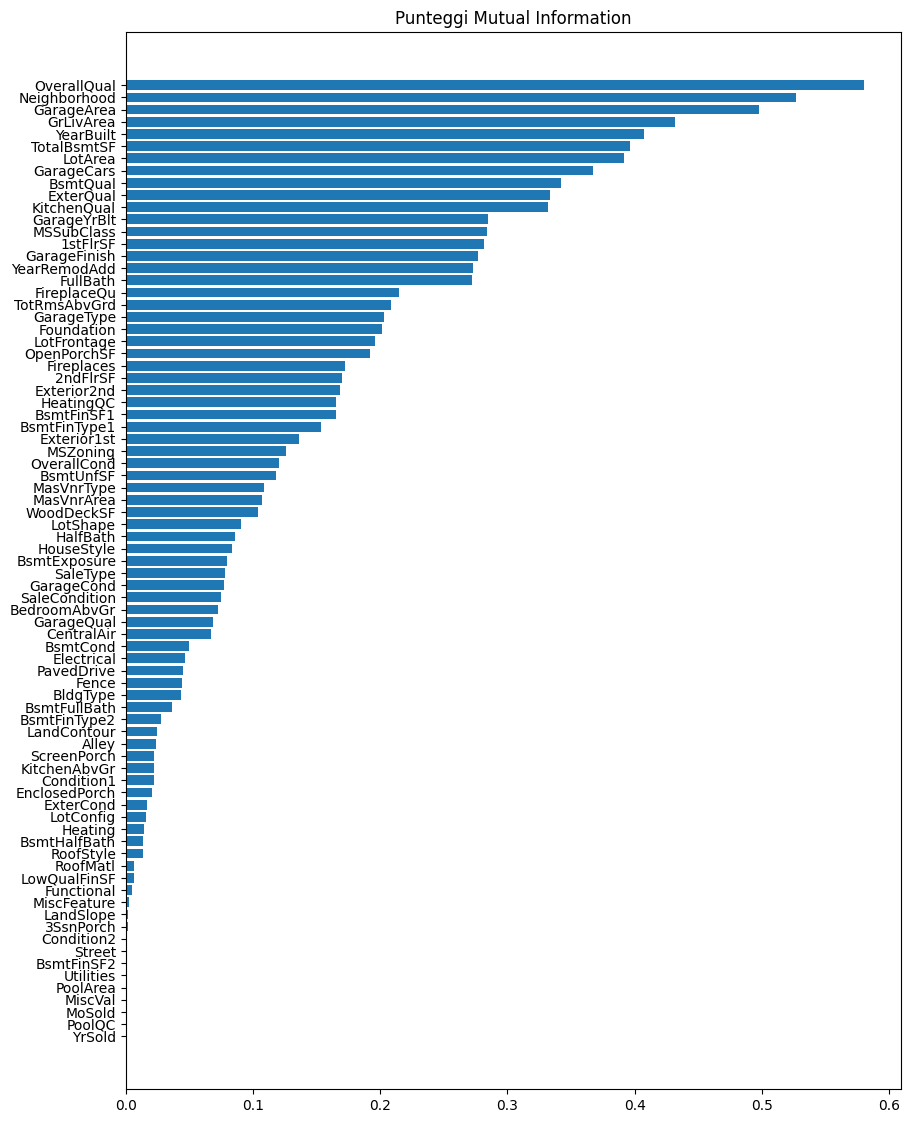

In [125]:
plt.figure(dpi=100, figsize=(10, 14))
plot_mi_scores(scores)

In questo scatter plot mostro a video le relazioni dirette, mettendo a confronto la feature che voglio col prezzo. Questo mi permette di capire bene o male che relazione(singola) c'è tra feature *x* e target variable *y*.(La feature sull'asse delle x è a piacere). Si noti che uso il dataset originale per "plottare" i dati, in quanto mi serve, in un solo dataset, sia la feature che la target)

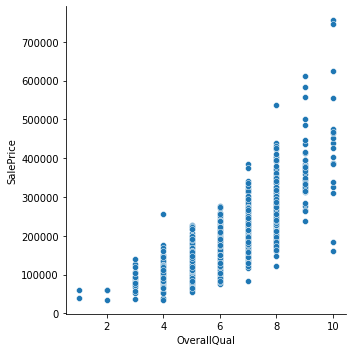

In [140]:
sns.relplot(x = "OverallQual", y = "SalePrice", data = train_df)

In questo plot invece si cerca di capire la correlazione feature -> variabile target discriminata da una terza variabile. Generalmente è meglio effettuare questa discriminazione con una seconda feature che abbia un più o meno ristretto set di valori, altrimenti il risultato potrebbe essere tanto complesso quanto inutile.

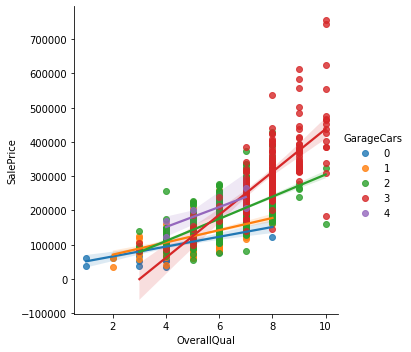

In [138]:
sns.lmplot(x = "OverallQual", y = "SalePrice", hue = "GarageCars", data = train_df)

Un prossima passo abbastanza importante per il feature-engineering è quello della creazione di nuove feature ove possibile. In questo caso, dato che le feature sono documentate e hanno un """"senso reale"""", è facile, con un po' di esperienza del dominio, comporle, scomporle o trasformarle per crearne altre(di cui poi l'utilità verrà misurata sempre con il MI score)

In [141]:
print(X_train.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [144]:
# Una feature facilmente creabile da questo caso d'uso è per esempio il totale 
# dei metri quadri abitabili(1stFlrSF + 2stFlrSF + GrLivArea)
X_train["TotalLivArea"] = X_train["1stFlrSF"] + X_train["2ndFlrSF"] + X_train["GrLivArea"]

# Un'altra misura significativa potrebbe essere l'area totale dei portici(esempio
# abbastanza americano, ma potremmo vederli come i balconi/terrazze europei)
X_train["TotalPorchArea"] = X_train["OpenPorchSF"] + X_train["EnclosedPorch"] + X_train["3SsnPorch"] + X_train["ScreenPorch"]

# Altra feature magari più immediata di quella dei porticati potrebbe essere il
# rapporto tra area abitabile e area totale del terreno(un rapporto vicino all'1
# indica una prevalenza di area abitabile rispetto a giardini/garage/etc, un 
# rapporto vicino allo 0 indica un'area praticamente quasi per nulla abitabile)
# N.B. qui addirittura stiamo creando una feature da un'altra feature creata
# precedentemente, quindi questo è un processo iterabile
X_train["HouseAreaOverTotArea"] = (X_train["TotalLivArea"] + X_train["GarageArea"]) / X_train["LotArea"]

# Feature magari meno importante, ovvero il # totale di bagni nella casa
X_train["TotBath"] = X_train["BsmtFullBath"] + X_train["BsmtHalfBath"] + X_train["FullBath"] + X_train["HalfBath"]

Adesso giusto per un po' di sicurezza in più calcoliamo il MI score delle nuove variabili create. Devo ricordarmi di aggiornare discrete_features, dato che funge da maschera booleana per indicare alla funzione quali feature sono discrete e quali no). Incredibilmente il totale dei bagni ha una forte correlazione con la variabile target.

In [150]:
discrete_features = X_train.dtypes == int
new_features_mi_score = calc_mi_score(X_train, y_train, discrete_features)

print(new_features_mi_score["TotalLivArea"])
print(new_features_mi_score["TotalPorchArea"])
print(new_features_mi_score["HouseAreaOverTotArea"])
print(new_features_mi_score["TotBath"])

0.44426250675653645
0.14169567390532212
0.12721513353902836
0.31391875874758046


Un'altra importante trasformazione che possiamo fare è quella della clusterizzazione. è normalissimo che dati, in base ad una discriminanete e una relazione più o meno lineare, si comportino in modi differenti. Queste trasformazioni sono generalmente frutto di esperienza, intuito e forte conoscenza del dominio, quindi non professerò di averle trovato da solo.
Generalmente comunque la clusterizzazione può aiutare a spezzare una relazione complicata in diverse relazioni lineari, più facili da afferrare/imparare dal modello.

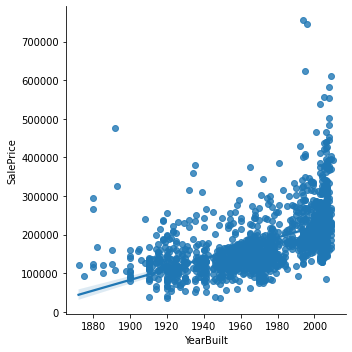

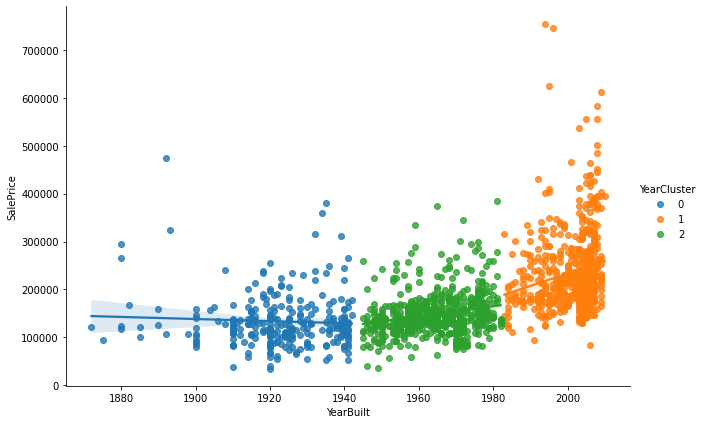

In [187]:
# La relazione tra l'anno di costruzione e il prezzo per esempio sembra essere esponenziale.
sns.lmplot(x = "YearBuilt", y = "SalePrice", data = train_df)

# Possiamo spezzarla per esempio in diverse sotto-relazioni lineari clusterizzando i punti per anno di costruzione

X_train_year = X_train.loc[:, ["YearBuilt"]]

X_train_tmp = train_df.copy()
kmean = KMeans(n_clusters = 3)
X_train_tmp["YearCluster"] = kmean.fit_predict(X_train_year)
X_train["YearCluster"] = X_train_tmp["YearCluster"] = X_train_tmp["YearCluster"].astype("category")

sns.lmplot(x = "YearBuilt", y = "SalePrice", hue = "YearCluster", data = X_train_tmp, height=6, aspect=1.5)

Come possiamo vedere, adesso sarà molto più semplice per il modello imparare la dipendenza lineare tra anno di costruzione e prezzo di vendita, appoggiandosi al cluster di cui fanno parti i vari anni di costruzione.

Ora, la cosa più difficile fin'ora, la PCA. Questa parte sarà meno argomentata, dato che è più una scoperta/test che una documentazione della tecnica appresa. Potrei fare la PCA di bene o male tutte le feature numeriche a disposizione, ma la applico solo ad un ristretto sottoinsieme(in particolare le feature con un alto MI score).

In [190]:
def apply_pca(X, standardize=True):
    # Standardizzo i valori, dato che il PCA lavora (praticamente solo) su valori standardizzati 
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Creo il dataframe risultate
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Creo i loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # faccio la transposta della matrice dei componenti
        columns=component_names,  # in modo che le colonne saranno i componenti stessi
        index=X.columns,  # mentre le righe le feature originali
    )
    return pca, X_pca, loadings

In [192]:
def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componenti", title="% Varianza Generata", ylim=(0.0, 1.0)
    )
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componenti", title="% Varianza Cumulata", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=8, dpi=100)
    return axs

Scelgo le feature che ritengo importanti, le copio in un array a parte e vi applico la PCA.

In [204]:
features = ["GarageArea", "GrLivArea", "TotalBsmtSF", "LotArea"]

X_train_var_pca = X_train.loc[:, features]

pca, X_pca, loadings = apply_pca(X_train_var_pca)

print(pca)
print("####################################################################################################")
print(X_pca)
print("####################################################################################################")
print(loadings)

PCA()
####################################################################################################
           PC1       PC2       PC3       PC4
0     0.064342 -0.292267 -0.525247 -0.385251
1    -0.070607 -0.073606  0.644681  0.190277
2     0.470400 -0.168702 -0.495490 -0.521673
3     0.220197 -0.316438 -0.602335 -0.861443
4     1.850572 -0.422060 -0.630670 -0.865998
...        ...       ...       ...       ...
1455 -0.118125 -0.213202 -0.361612  0.026085
1456  1.339433 -0.064836 -0.137027  0.784593
1457  0.363941  0.028044 -1.260852  1.369549
1458 -1.035230  0.394700  0.517223  0.627763
1459 -0.532169  0.263781  0.520889  0.822648

[1460 rows x 4 columns]
####################################################################################################
                  PC1       PC2       PC3       PC4
GarageArea   0.534155 -0.352363  0.146735 -0.754312
GrLivArea    0.541526 -0.109034 -0.784507  0.281798
TotalBsmtSF  0.547112 -0.135367  0.600298  0.567438
LotArea      0.3494

Calcolo i valori MI per capire se effettivamente hanno senso le componenti risultati e faccio un po' di data-visualization

MI Scores per le componenti principali:
PC1    0.693320
PC2    0.183847
PC3    0.177369
PC4    0.075445
Name: Punteggi mutual information, dtype: float64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f575bfc5b10>,
      dtype=object)

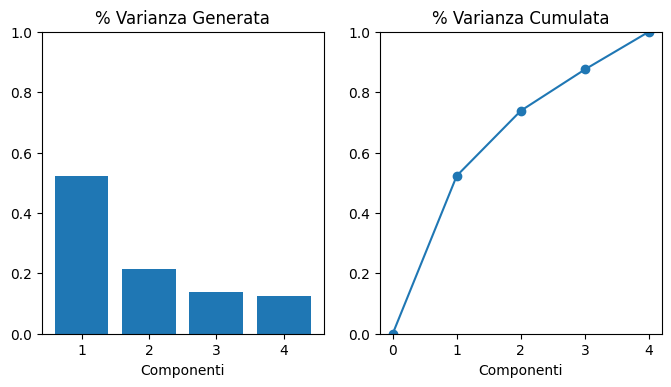

In [215]:
discrete_features_pca = [pd.api.types.is_integer_dtype(t) for t in X_pca.dtypes]
pca_scoring = calc_mi_score(X_pca, y_train, discrete_features_pca)
print(f"MI Scores per le componenti principali:\n{pca_scoring}")

plot_variance(pca)

A questo punto aggiungo le componenti principali al dataset, in modo da utilizzarle poi nella parte di addestramento.

In [216]:
X_train = X_train.join(X_pca)

# **Addestramento del modello**

A questo punto abbiamo preparato a dovere i nostri dati e possiamo creare e addestrare il modello. Come modello di base usiamo il "XGBRegressor", ma è personalizzabile(parametro della funzione)

In [219]:
def evaluate_dataset(X, y, model=XGBRegressor()):
    # Codifico le feature qualificative in quantitative
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Calcolo l'errore del modello con il RMSLE (Root Mean Squared Log Error), dato che è quello usato per
    # valutare la submission
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [222]:
score = evaluate_dataset(X_train, y_train)
print(f"Your score: {score:.5f} RMSLE")

[14:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Your score: 0.13284 RMSLE


In [224]:
model = XGBRegressor(verbosity = 1)
model.fit(X_train, y_train)

[14:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [226]:
model_score = cross_val_score(model, X_train, y_train, cv = 10)
print(f"Il punteggio del modello in training è : {model_score.mean()}")

[14:53:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [235]:
X_test["TotalLivArea"] = X_test["1stFlrSF"] + X_test["2ndFlrSF"] + X_test["GrLivArea"]
X_test["TotalPorchArea"] = X_test["OpenPorchSF"] + X_test["EnclosedPorch"] + X_test["3SsnPorch"] + X_test["ScreenPorch"]
X_test["HouseAreaOverTotArea"] = (X_test["TotalLivArea"] + X_test["GarageArea"]) / X_test["LotArea"]
X_test["TotBath"] = X_test["BsmtFullBath"] + X_test["BsmtHalfBath"] + X_test["FullBath"] + X_test["HalfBath"]

X_test_year = X_test.loc[:, ["YearBuilt"]]
X_test_tmp = test_df.copy()
X_test_tmp["YearCluster"] = kmean.fit_predict(X_test_year)
X_test["YearCluster"] = X_test_tmp["YearCluster"] = X_test_tmp["YearCluster"].astype("category")

X_test_var_pca = X_test.loc[:, features]
pca, X_pca_test, loadings_test = apply_pca(X_test_var_pca)

X_test = X_test.join(X_pca_test)

In [237]:
for col in X_test.select_dtypes(["category", "object"]):
  X_test[col], _= X_test[col].factorize()

X_test = fillNaN(X_test)
y_test = model.predict(X_test)

In [238]:
print(y_test)

[133107.06  158425.03  176849.44  ... 175899.48  120670.695 238772.39 ]


In [250]:
submission = pd.read_csv("./house-prices-advanced-regression-techniques/sample_submission.csv")
submission["SalePrice"] = y_test
submission.to_csv("/content/drive/MyDrive/submission_house_pricing.csv", index = False, encoding='utf-8-sig')